<a href="https://colab.research.google.com/github/bartianbosch/Melk/blob/Oscar/Big_Data_Milk_Oscar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Big Data Groupwork Milk


In [ ]:
# To download and update the necessary requirements, run this cell
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 https://developer.download.nvidia.com/compute/cuda/repo

In [45]:
# To initialize Apache Spark, run this cell
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
sp = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# Added imports
from pyspark import SparkFiles

import pandas as pd
import matplotlib.pyplot as plt
plt.close('all')
plt.rcParams['figure.figsize'] = [30, 20]

# Mounting drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Loading the data into a DF


In [46]:
# Work from dataframes is sufficient
url = 'https://raw.githubusercontent.com/bartianbosch/Melk/main/ff_dairy_v1.csv'

spark.sparkContext.addFile(url)

milk_rdd = spark.read.csv(SparkFiles.get("ff_dairy_v1.csv"), header=True)


# Also loading to pandas table just in case we need it for testing
milk_pd=pd.read_csv(url, encoding='latin1')


In [ ]:
milk_pd

,Cow number,Date,Barn,Barn part,Treatment,Lactation number,Days in milk,Day number,Week,"Period (VP = preperiod, HP = trial period)","Period part (VP = preperiod, HP = trial period)",Intake basal ration (kg dm),Intake total ration (kg dm),Water intake (kg),Concentrate intake (kg),Weight (kg),BCS,Backfat Thickness,Milk yield (kg),Fat%,Protein%,Urea (mg/kg),SCC (*1000/ml),Lactose%,Avg. Temperature (¡C),Air speed,Max. temperature (¡C),Rumination time (min/day),Avg. pH,Avg. Rumen Temperature,"Time pH<5,8 (h)","Manure consistency (1=fluid, 5= hard)","Manure fibre score (1=short, 5 = long)",Number of kernels,Manure sieving residu (%),Manure dm (g/kg OM),Manure starch (g/kg dm),Urin-pH,Intake pre-period (kg dm),Milk yield prepreriod (kg),...,Mg (g/day),nXP (g/day),RNB (g/day),MELK (g/day),NEL (g/day),WDE (g/day),EKB (g/day),WDS (g/day),SPK (g/day),TPK (g/day),SPE (g/day),TPE (g/day),I (/day),WI (/day),GP (g/day),Crude fiber (g/kg dm),Sugar (g/kg dm),Crude protein (g/kg dm),Crude fat (g/kg dm),Starch (g/kg dm),Ca (g/kg dm),P (g/kg dm),Na (g/kg dm),Cl (g/kg dm),K (g/kg dm),Mg (g/kg dm),nXP (g/kg dm),RNB (g/kg dm),MELK (/kg dm),NEL (MJ/kg dm),WDE (g/kg dm),EKB (g/kg dm),WDS (g/kg dm),SPK (g/kg dm),TPK (g/kg dm),SPE (g/kg dm),TPE (g/kg dm),I (/kg dm),WI (/kg dm),GP (g/kg dm)
0,61,16/6/14,6.0,2,O,9,71,0,0,0,0,NaN,NaN,88.2,NaN,627.5,NaN,NaN,40.47,3.55,2.89,211.0,22.0,4.76,16.5,1.4,19.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.22,38.63,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,61,17/6/14,6.0,2,O,9,72,1,1,VP,VP1,19.9,24.3,94.6,4.875,595.0,NaN,NaN,38.29,NaN,NaN,NaN,NaN,NaN,18.0,1.6,22.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.22,38.63,...,79,3829,20,26394,169,2198,388,1401,4761,10783,1535,2561,2590,2726,3396,166,45,162,36,226,6,4,2,5,15,3,158,1,1087,7,91,16,58,196,444,63,105,107,112,140
2,61,18/6/14,6.0,2,O,9,73,2,1,VP,VP1,17.7,22.0,92.9,4.875,609.0,NaN,NaN,39.28,NaN,NaN,NaN,NaN,NaN,17.5,1.2,23.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.22,38.63,...,71,3484,20,23945,154,2010,354,1280,4314,9749,1383,2323,2343,2429,3079,164,46,163,36,227,6,5,2,5,15,3,158,1,1088,7,91,16,58,196,443,63,106,106,110,140
3,61,19/6/14,6.0,2,O,9,74,3,1,VP,VP1,16.5,21.1,97.6,5.125,614.0,NaN,NaN,38.16,NaN,NaN,NaN,NaN,NaN,15.9,1.6,17.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.22,38.63,...,68,3355,22,22989,148,1945,341,1239,4137,9327,1318,2230,2243,2289,2954,161,46,164,36,228,6,5,2,4,14,3,159,1,1088,7,92,16,59,196,442,62,106,106,108,140
4,61,20/6/14,6.0,2,O,9,75,4,1,VP,VP1,20.2,24.8,106.6,5.125,614.0,NaN,NaN,44.06,NaN,NaN,NaN,NaN,NaN,15.6,1.9,18.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.22,38.63,...,80,3911,22,26938,173,2249,396,1433,4858,10994,1563,2614,2641,2768,3466,165,45,162,36,227,6,5,2,5,15,3,158,1,1087,7,91,16,58,196,444,63,105,107,112,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8777,901,11/9/14,6.0,6,M,1,113,87,13,HP,HP3,13.6,16.3,62.2,3.024,555.5,NaN,NaN,19.80,NaN,NaN,NaN,NaN,NaN,17.4,1.6,22.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.67,23.95,...,52,2061,0,17762,113,1472,239,883,3341,7363,1052,1742,1811,1847,2277,166,44,161,35,233,6,4,2,5,15,3,127,0,1092,7,91,15,54,205,453,65,107,111,114,140
8778,901,12/9/14,6.0,6,M,1,114,88,13,HP,HP3,12.4,15.1,82.6,3.024,557.0,NaN,NaN,23.14,NaN,NaN,NaN,NaN,NaN,17.4,1.4,24.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.67,23.95,...,48,1880,0,16478,105,1373,221,820,3106,6820,972,1617,1682,1691,2110,165,45,162,35,234,6,4,2,5,14,3,125,0,1093,7,91,15,54,206,452,64,107,112,112,140
8779,901,13/9/14,6.0,6,M,1,115,89,13,HP,HP3,7.9,10.6,41.6,3.028,544.0,NaN,NaN,18.87,NaN,NaN,NaN,NaN,NaN,18.4,1.7,23.4,NaN,NaN,NaN,NaN,NaN,Na

In [47]:
milk_rdd.show(5)

+----------+-------+----+---------+---------+----------------+------------+----------+----+------------------------------------------+-----------------------------------------------+---------------------------+---------------------------+-----------------+-----------------------+-----------+----+-----------------+---------------+----+--------+------------+--------------+--------+---------------------+---------+---------------------+-------------------------+-------+-----------------------+---------------+-------------------------------------+--------------------------------------+-----------------+-------------------------+-------------------+-----------------------+-------+-------------------------+--------------------------+--------------+------------------+------------------+----------------------+------------------+--------+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+----------+----------+---------+----------+-------

# Question 1: 

Which combination of nutrients is the best predictor for the fat yield (milk yield * fat %) ?

In [ ]:
# Select the yield column and fat% column

yield_col = milk_rdd.select('Milk yield (kg)')
fat_pc_col = milk_rdd.select('Fat%')

yield_col.take(5)
yield_col.show(5)

yield_fat = map(lambda x, y : x*y, (yield_col, fat_pc_col))
yield_fat.alias('Fat yield')



+---------------+
|Milk yield (kg)|
+---------------+
|          40.47|
|          38.29|
|          39.28|
|          38.16|
|          44.06|
+---------------+
only showing top 5 rows



AttributeError: ignored

In [ ]:
# select the nutrient columns in g/day

# crude fiber, sugar, crude protein, crude fat, starch, Ca, P, Na, Cl, K, Mg, WDS, SPK, TPK, SPE, TPE, +I, Wi, GP 
# intestines: nXP, RNB, MELK, NEL, WDE, EKB

cr_fiber_col = milk_rdd.select('Crude fiber (g/day)')
sugar_col = milk_rdd.select('Sugar (g/day)')
cr_protein_col = milk_rdd.select('Crude protein (g/day)')
cr_fat_col = milk_rdd.select('Crude fat (g/day)')
starch_col = milk_rdd.select('Starch (g/day)')

ca_col = milk_rdd.select('Ca (g/day)')
p_col = milk_rdd.select('P (g/day)')
na_col = milk_rdd.select('Na (g/day)')
cl_col = milk_rdd.select('Cl (g/day)')
k_col = milk_rdd.select('K (g/day)')
mg_col = milk_rdd.select('Mg (g/day)')



In [ ]:
# create linear regression models 

import seaborn as sns 

sns.scatterplot(x = milk_rdd.select(*), y = milk_rdd.select(*))

SyntaxError: ignored



---


## Oscars Playground


   Cow number     Date  Barn  ...  I (/kg dm) WI (/kg dm)  GP (g/kg dm)
0          61  16/6/14   6.0  ...          NaN         NaN           NaN
1          61  17/6/14   6.0  ...          107         112           140
2          61  18/6/14   6.0  ...          106         110           140
3          61  19/6/14   6.0  ...          106         108           140
4          61  20/6/14   6.0  ...          107         112           140

[5 rows x 96 columns]
Index(['Cow number', 'Date', 'Barn', 'Barn part', 'Treatment',
       'Lactation number', 'Days in milk', 'Day number', 'Week',
       'Period (VP = preperiod, HP = trial period)',
       'Period part (VP = preperiod, HP = trial period)',
       'Intake basal ration (kg dm)', 'Intake total ration (kg dm)',
       'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS',
       'Backfat Thickness', 'Milk yield (kg)', 'Fat%', 'Protein%',
       'Urea (mg/kg)', 'SCC (*1000/ml)', 'Lactose%', 'Avg. Temperature (¡C)',
       'A

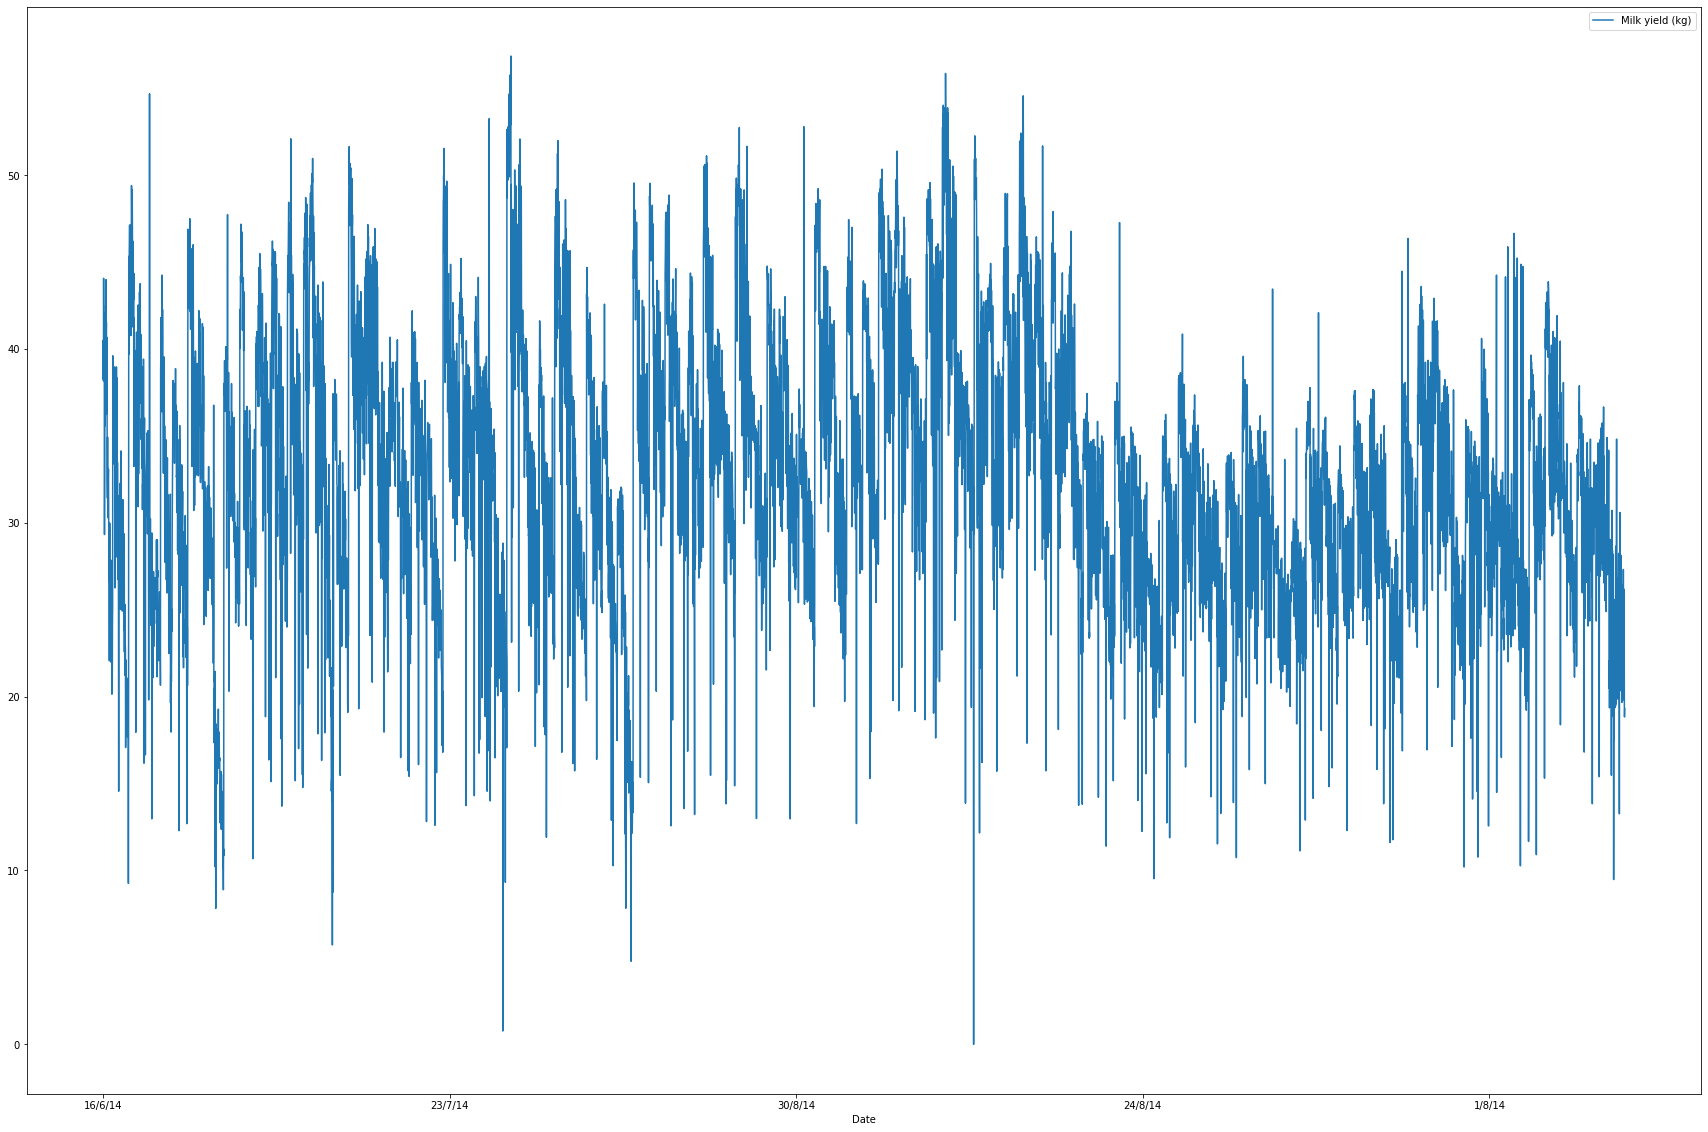

In [49]:
# Pandas Visualization
print(milk_pd.head())
print(milk_pd.columns)

milk_pd.plot( x='Date',y='Milk yield (kg)')

print(milk_pd['I (/kg dm)'])



---

